PACCHETTI, LIBRERIE E VARIE

In [1]:
# For a jupyter notebook add the following line:
%matplotlib inline

# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

In [2]:
from mesa import Agent, Model

from mesa.time import RandomActivation
#from mesa.time import SimultaneousActivation #bisogna aggiungere advance agli agenti
#from mesa.time import StagedActivation #dividere le azioni di un agenti (probabilmente inutile per noi)
#from mesa.time import BaseScheduler

from mesa.datacollection import DataCollector

from mesa.space import MultiGrid

import numpy as np

import random
import math

from mesa.batchrunner import BatchRunner
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import ttest_1samp

IL MODELLO

In [77]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

def compute_tot_tax_per(model):
    c=model.cassacomune
    p=model.counter_prelievi
    t=c+p
    t_p=(t*model.periodo_tassazione)/((model.temperature*model.num_agents-model.temperature)*100) #considera standar 100 passi, espressa in decimali
    return t_p

def compute_tax_per_gdp(model):
    if model.counter_turni>1:
        c=model.cassacomune
        p=model.counter_prelievi
        t=c+p
        gdp=model.counter_gdp
        t_p=t/gdp
        return t_p
    
def return_gdp(model):
    gdp=model.counter_gdp
    return gdp

class MoneyAgent(Agent): #Each model will contain multiple agents, all of which are instantiations of the agent class
    def __init__(self, unique_id, model): #inizializza agenti con unico id
        super().__init__(unique_id, model)
        self.wealth = self.model.temperature# wealth iniziale

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1: #controlla se nella cella c'è qualcun altro
            other = self.random.choice(cellmates)
            while self is other: #esclude di fare scambi con se stessi
                other = self.random.choice(cellmates)
                
            #YARD-SALE follow the money example,winner take-all, nota che quando qualcuno perde tutto non può più tornare indietro
#            if self.wealth>other.wealth:
 #               transazione=random.choice(range(other.wealth+1))
  #              taxed=0
   #             if (self.model.counter_turni)%self.model.periodo_tassazione==0:
    #                taxed=round(transazione*self.model.aliquota_income)
     #           gain=transazione-taxed
      #          other.wealth+=gain
       #         self.wealth-=transazione
        #        self.model.counter_gdp+=transazione
         #       if taxed>0:
          #          self.model.cassacomune+=taxed
           #         self.model.counter_riscossioni+=1
            #elif self.wealth<=other.wealth:
             #   transazione=random.choice(range(self.wealth+1))
              #  taxed=0
               # if (self.model.counter_turni)%self.model.periodo_tassazione==0:
                #    taxed=round(transazione*self.model.aliquota_income)
#                gain=transazione-taxed
 #               other.wealth+=gain
  #              self.wealth-=transazione
   #             self.model.counter_gdp+=transazione
    #            if taxed>0:
     #               self.model.cassacomune+=taxed
      #              self.model.counter_riscossioni+=1

            
            #MARRIAGE-DIVORCE, random split, e^(-wT)
            #tot=self.wealth+other.wealth
            #self.wealth=random.choice(range(tot+1))
            #other.wealth=tot-self.wealth
            
            #THELF AND FRAUD
            loss=random.choice(range(self.wealth+1))
            taxed=0
            if (self.model.counter_turni)%self.model.periodo_tassazione==0:
                taxed=round(loss*self.model.aliquota_income)
            gain=loss-taxed
            other.wealth+=gain
            self.wealth-=loss
            self.model.counter_gdp+=loss
            if taxed>0:
                self.model.cassacomune+=taxed
                self.model.counter_riscossioni+=1
            
            #BASIC ONE
            #other.wealth += 1 
            #self.wealth -= 1
            
    def step(self): #step method
        self.move()
        if self.wealth > 0:
            self.give_money()        
        if ((self.model.counter_turni)%self.model.periodo_tassazione==0): #tasso e reditribuisco solo nei turni multipli di P
            self.tax()
        if(self.wealth<self.model.temperature)&(self.model.cassacomune>0):
            self.wealth+=1
            self.model.cassacomune-=1
            self.model.counter_prelievi+=1
    
    def tax(self):
        delta=self.wealth-self.model.temperature
        t=self.model.tassa_fissa+round(self.model.aliquota_proporzionale*delta+self.model.aliquota_progressiva*(delta**2))
        if (delta>0)&(self.wealth-t>self.model.temperature)&(t>0):
            self.wealth-=t
            self.model.cassacomune+=t
            self.model.counter_riscossioni+=1
        elif (delta>0)&(self.wealth-t<=self.model.temperature):
            self.wealth-=delta
            self.model.cassacomune+=delta
            self.model.counter_riscossioni+=1

class MoneyModel(Model): #The model class holds the model-level attributes, manages the agents, and generally handles the global level of our model. Each instantiation of the model class will be a specific model run
    def __init__(self, N, width, height, c, a, b, T,P,ai): #inizializza modello,parametri AGGIUNGI c,a E b
        self.num_agents = N # N numero di agenti
        self.tassa_fissa = c
        self.aliquota_proporzionale = a
        self.aliquota_progressiva = b
        self.temperature = T
        self.periodo_tassazione = P
        self.aliquota_income = ai
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self) #specifica tipo scheduler
        self.running = True
        
        #Create cassa
        self.cassacomune=0
        #create counter prelievi e riscossioni
        self.counter_prelievi=0
        self.counter_riscossioni=0
        #contatore turni
        self.counter_turni=1
        self.counter_gdp=0

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini,"Totale tax % benessere": compute_tot_tax_per, "Bilancio": "cassacomune","Numero prelievi":"counter_prelievi","Numero riscossioni":"counter_riscossioni","GDP": return_gdp, "Tax % GDP": compute_tax_per_gdp},
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step() #fa avanzare il modello        
        self.counter_turni+=1

RUN!

In [78]:
#scegli i parametri

n=100 #numero agenti
t=100 #numero passi
T=5 #wealth iniziale per agente o temperatura, usato anche come soglia di redistribuzione

c=1 #tassa fissa
a=0.03 #aliquota proporzionale
b=0.04 #aliquota prograssiva
ai=0.01 #ailiquota on income

P=10 #periodo di tassazione

In [79]:
#runna il modello

model = MoneyModel(n,10,10,c,a,b,T,P,ai) #agenti, griglia e tasse
for i in range(t):
    model.step()

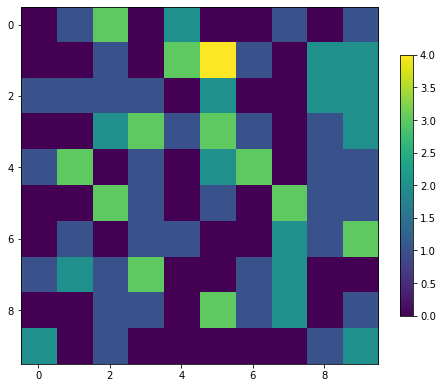

In [80]:
agent_counts = np.zeros((model.grid.width, model.grid.height)) #number of agents residing in each cell, lol
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar(shrink=0.6)

In [81]:
agent_wealth = model.datacollector.get_agent_vars_dataframe() #all the story
end_wealth = agent_wealth.xs(t-1, level="Step")["Wealth"] #final distribution
model_situation = model.datacollector.get_model_vars_dataframe()
bilancio=model_situation['Bilancio']
print("Denaro totale iniziale: "+str(T*n))
print("Denaro privato finale: "+str(sum(end_wealth)))
print("Denaro pubblico finale: "+str(bilancio[t-1]))
print("Non è stato perso nessun fiorino: "+str(sum(end_wealth)+bilancio[t-1]==T*n))
print("Sono state effettuate "+str(model_situation['Numero riscossioni'][t-1])+" riscossioni")
print("Sono stati effettuati "+str(model_situation['Numero prelievi'][t-1])+" prelievi")
tot_tax=bilancio[t-1]+model_situation['Numero prelievi'][t-1]
print("In totale tassato è: "+str(tot_tax))

print("che corrisponde al "+str((tot_tax*100*P)/((T*n-T)*t))+"% dell'imponibile sul benessere")
print("che corrisponde al "+str(tot_tax/model_situation['GDP'][t-1])+"% del GDP")

Denaro totale iniziale: 500
Denaro privato finale: 500
Denaro pubblico finale: 0
Non è stato perso nessun fiorino: True
Sono state effettuate 233 riscossioni
Sono stati effettuati 979 prelievi
In totale tassato è: 979
che corrisponde al 19.77777777777778% dell'imponibile sul benessere
che corrisponde al 0.0557612348351085% del GDP


la percentuale dell'imponibile è calcolata dividendo il totale tassato per il numero di tasse che si sarebbe riscosso se ogni turno di tassazione solo uno avesse avuto tutta la ricchezza e si fosse usata una tassa d'esproprio

In [8]:
model_situation

,Gini,Totale tax % benessere,Bilancio,Numero prelievi,Numero riscossioni,GDP,Tax % GDP
0,0.00000,0.000000,0,0,0,0,NaN
1,0.32824,0.000000,0,0,0,153,0.000000
2,0.47704,0.000000,0,0,0,262,0.000000
3,0.52600,0.000000,0,0,0,352,0.000000
4,0.55144,0.000000,0,0,0,425,0.000000
...,...,...,...,...,...,...,...
95,0.61988,0.330505,0,1636,261,6799,0.240624
96,0.63048,0.330505,0,1636,261,6858,0.238554
97,0.65008,0.330505,0,1636,261,6907,0.236861
98,0.72140,0.330505,0,1636,261,6986,0.234183


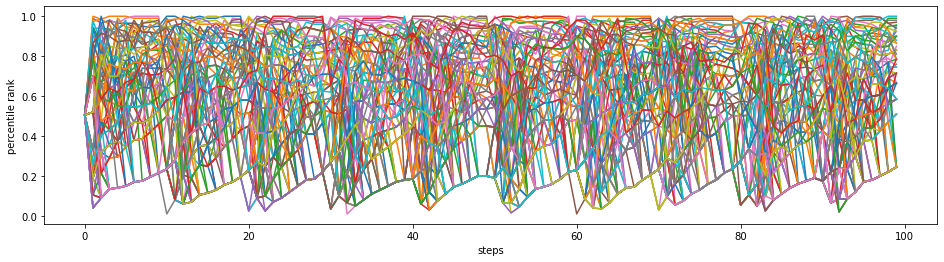

In [9]:
#rank story

rank=[]
for i in range(t): #per ogni step
    step_wealth=agent_wealth.xs(i, level="Step")
    l=list(step_wealth['Wealth'].rank(pct=True).to_numpy())
    rank+=l
agent_wealth['Rank']=rank

plt.rcParams['figure.figsize'] = [16, 4]
for j in range(n):
    plt.plot(agent_wealth['Rank'].xs(j, level="AgentID"))

plt.xlabel('steps')
plt.ylabel('percentile rank')

plt.show()

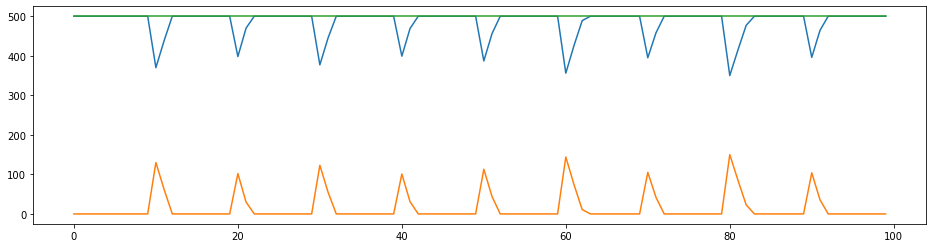

In [10]:
#NOTA: vedi solo i saldi di fine turno

sum_wealth=[sum(agent_wealth.xs(j, level="Step")["Wealth"]) for j in range(t)]
plt.plot(sum_wealth)
plt.plot(bilancio)
plt.plot(sum_wealth+bilancio)

In [11]:
#valuta tassa e redistribuzione
wealth=range(0,50)

tax=[]
for i in wealth:
    d=i-T
    tax_i=c+round(a*d+b*d**2)
    if (d>0)&(i-tax_i>T):
        tax.append(-tax_i)
    elif (d>0)&(i-tax_i<=T):
        tax.append(-i+T)
    elif (d<0):
        tax.append(1)
    elif (d==0):
        tax.append(0)

wealth_tax=list(zip(wealth,tax))
print(wealth_tax)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 0), (6, -1), (7, -1), (8, -1), (9, -2), (10, -2), (11, -3), (12, -3), (13, -4), (14, -5), (15, -5), (16, -6), (17, -7), (18, -8), (19, -9), (20, -10), (21, -12), (22, -13), (23, -15), (24, -16), (25, -18), (26, -19), (27, -21), (28, -23), (29, -24), (30, -25), (31, -26), (32, -27), (33, -28), (34, -29), (35, -30), (36, -31), (37, -32), (38, -33), (39, -34), (40, -35), (41, -36), (42, -37), (43, -38), (44, -39), (45, -40), (46, -41), (47, -42), (48, -43), (49, -44)]


In [12]:
n_tax1=[-x for x in tax]

In [13]:
n_tax2=[-x for x in tax]

In [14]:
n_tax3=[-x for x in tax]

Text(0, 0.5, 'Tax')

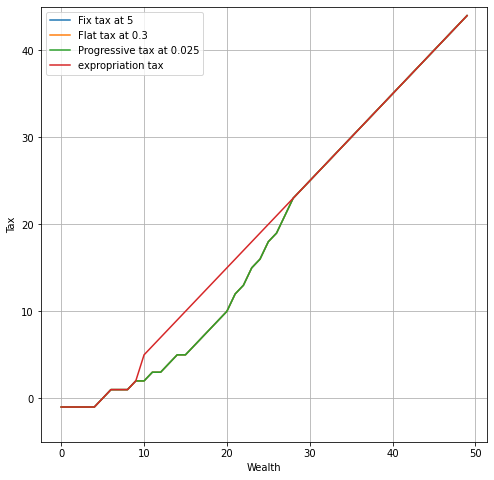

In [15]:
plt.rcParams['figure.figsize'] = [8, 8]

plt.plot(wealth,n_tax1, label='Fix tax at 5')
plt.plot(wealth,n_tax2, label='Flat tax at 0.3')
plt.plot(wealth,n_tax3, label='Progressive tax at 0.025')

wealth_expr=n_tax1[0:10]+[x-T for x in wealth[10:]]
plt.plot(wealth,wealth_expr,label='expropriation tax')
plt.ylim([-5,45])
plt.grid()
plt.legend()
plt.xlabel('Wealth')
plt.ylabel('Tax')

ANALISI della run

In [16]:
agent_wealth.Wealth.describe()

count    10000.00000
mean         4.84350
std          5.60947
min          0.00000
25%          1.00000
50%          3.00000
75%          7.00000
max         64.00000
Name: Wealth, dtype: float64

In [17]:
#chiedi cose alla storia

#guarda uno step
#agent_wealth.xs(0, level="Step")

#guarda un agente
# agent_wealth.xs(0, level="AgentID")

#guarda uno step di un agente
#agent_wealth.xs((k-1,0), level=["Step","AgentID"])

#cerca gli agenti&step di un certo wealth
#agent_wealth.loc[agent_wealth['Wealth'] == 180]

#storia di qualcuno
#agent_wealth1 = agent_wealth.xs(1, level="AgentID") #specificare id di un agente
#agent_wealth1.Wealth.plot()

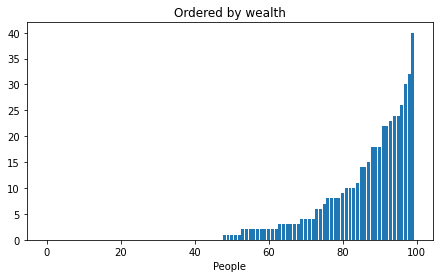

In [18]:
plt.rcParams['figure.figsize'] = [16, 4]

s_end_wealth=np.sort(end_wealth.values)

#plt.subplot(1, 2, 1) # row 1, col 2 index 1
#plt.bar(range(n),end_wealth)#bar or plot
#plt.plot([0,n],[T,T], color='y')
#plt.title("Ordered by ID")
#plt.xlabel('People')
#plt.ylabel('Wealth')

plt.subplot(1, 2, 2) # index 2
plt.bar(range(n),s_end_wealth)
#plt.plot([0,n],[T,T], color='y')
plt.title("Ordered by wealth")
plt.xlabel('People')

plt.show()

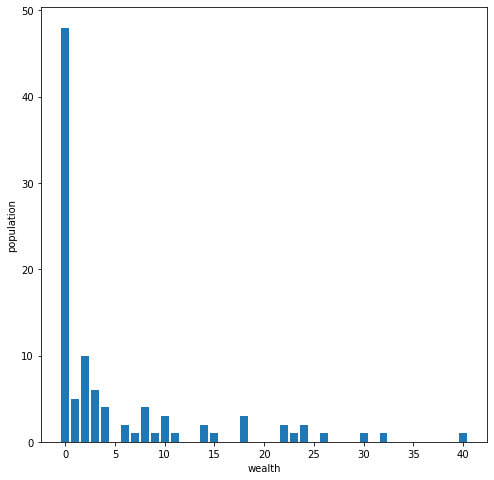

In [19]:
plt.rcParams['figure.figsize'] = [8, 8]

class_dis=[] #fix this
for r in range(end_wealth.max()+1): #per ogni ricchezza
    c=0 #inizializzo il conto per ogni classe sociale
    for j in end_wealth:
        if j==r:
            c+=1
    class_dis.append(c)
plt.bar(range(end_wealth.max()+1),class_dis, label='final distribution') #plot or bar

#e^(-wT)*intercetta
x_f=range(end_wealth.max()+1)
y_f=[]
for x in x_f:
    y=math.exp(-x*T)*class_dis[0]+1
    y_f.append(y)

#plt.plot(x_f,y_f, label='Boltzmann-Gibbs distribution approximation', color='y')

plt.xlabel('wealth')
plt.ylabel('population')
#plt.legend()
plt.show()

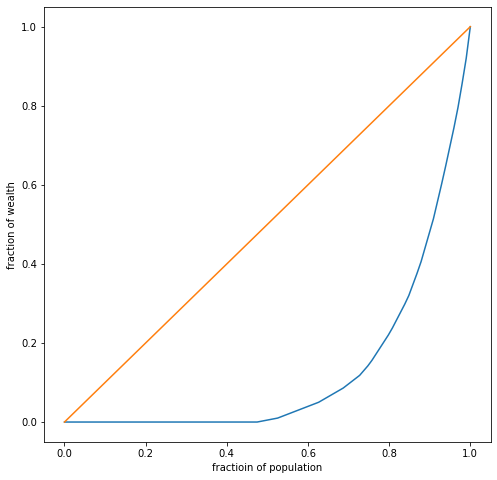

In [20]:
#Lorents curve
p_end_wealth=[x/(n*T) for x in s_end_wealth]
cum_p_end_wealth=np.cumsum(p_end_wealth)
eq_cu=[x/(n-1) for x in range(0,n)]

plt.plot(eq_cu,cum_p_end_wealth)
plt.plot(eq_cu,eq_cu)

plt.xlabel('fractioin of population')
plt.ylabel('fraction of wealth')
#plt.title('Lorenz curve')

plt.show()

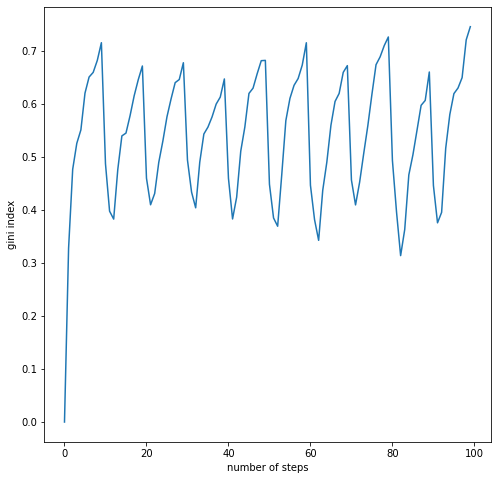

In [21]:
#indice della diseguaglianza
gini = model_situation['Gini']
gini.plot()

gini_l=list(gini)
t_a=int(t/2) #considero la seconda metà per calcolare la media
gini_l=gini_l[t_a:]
mean=sum(gini_l)/len(gini_l)
#plt.plot([0,t],[mean,mean], color='y')

plt.xlabel('number of steps')
plt.ylabel('gini index')

plt.show()

#scopri come ottenere il valore asimptotico

In [22]:
#valore asimptotico e valore iniziale
print(mean,list(gini)[0])

0.5437323459592468 0.0


BATCH RUN! changing tax

---Taxation on the wealth instead on the transactions---

PERCENTAGE LINEAR/PARABLE TAXATION:

fissa: T=c

proporzionale: T=a*w

progressiva o regressiva:

T_% = a +b*w

T = k +T_%*w

T = c +(a +b*w)*w = c +a*w +b*w^2

NOTA BENE: dal plot della parabola si deduce che per qualsiasi valore di b ad un certo punto le tasse supereranno il benessere,
quindi bisogna controllare quel punto critico

---redistribution--

how tax are redistributed?
when? how much? to who?

to everyone the same fraction?
only to some of the agent?
before or after transaction?

REDISTRIBUISCO A CHI HA MENO DEL BENESSERE INIZIALE

OGNI QUANTO TASSARE?

Valore decisi da me:

N persone =100

x,y spazio =10*10

Valori testati:

T temperature = 5

t steps (senza tasse) poco più che sufficienti a far emergere la distribuzione finale = 100

P periodo con tasse = 10

In [82]:
#def __init__(self, N, width, height, c, a, b, T,P)

fixed_params = {"N": 100,
                "width": 10,
                "height": 10,
                "a": 0,
                "b": 0,
                "T": 5,
                "P": 5,
                "ai": 0}

rangec=range(0,20,1)
variable_params = {"c": rangec}

batch_run1 = BatchRunner(MoneyModel,
                        variable_params,
                        fixed_params,
                        iterations=10,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini,"Tot_tax_per": compute_tot_tax_per})
batch_run1.run_all()

200it [03:10,  1.05it/s]


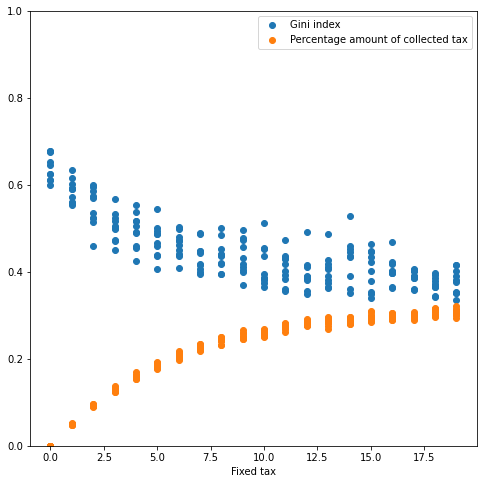

In [83]:
run_data1 = batch_run1.get_model_vars_dataframe()
run_data1.head()
plt.scatter(run_data1.c, run_data1.Gini, label='Gini index')
plt.scatter(run_data1.c, run_data1.Tot_tax_per, label='Percentage amount of collected tax')

plt.xlabel('Fixed tax')
plt.legend()
plt.ylim([0,1])
plt.show()

Text(0, 0.5, 'Gini index')

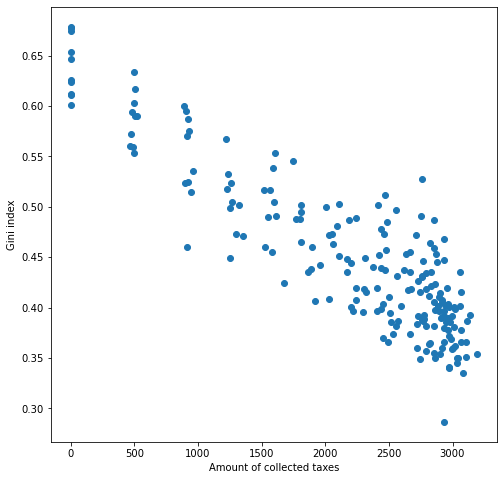

In [84]:
#scatter against tot tax

plt.scatter(run_data1.Tot_tax_per*(fixed_params['T']*fixed_params['N']-fixed_params['T'])*100/fixed_params['P'],run_data1.Gini)
plt.xlabel('Amount of collected taxes')
plt.ylabel('Gini index')

In [147]:
#def __init__(self, N, width, height, c, a, b, T,P)

fixed_params = {"N": 100,
                "width": 10,
                "height": 10,
                "c": 0,
                "b": 0,
                "T": 5,
                "P": 5,
                "ai": 0}

rangea=np.arange(0,1,0.02)
variable_params = {"a": rangea}

batch_run2 = BatchRunner(MoneyModel,
                        variable_params,
                        fixed_params,
                        iterations=10,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini,"Tot_tax_per": compute_tot_tax_per})
batch_run2.run_all()

500it [07:42,  1.08it/s]


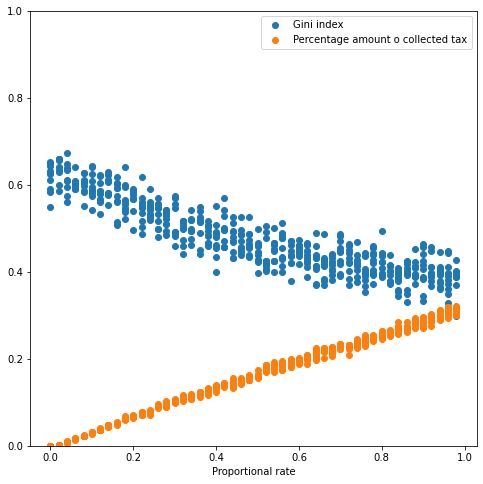

In [148]:
run_data2 = batch_run2.get_model_vars_dataframe()
run_data2.head()
plt.scatter(run_data2.a, run_data2.Gini, label='Gini index')
plt.scatter(run_data2.a, run_data2.Tot_tax_per, label='Percentage amount o collected tax')

plt.xlabel('Proportional rate')
plt.legend()
plt.ylim([0,1])
plt.show()

Text(0, 0.5, 'Gini index')

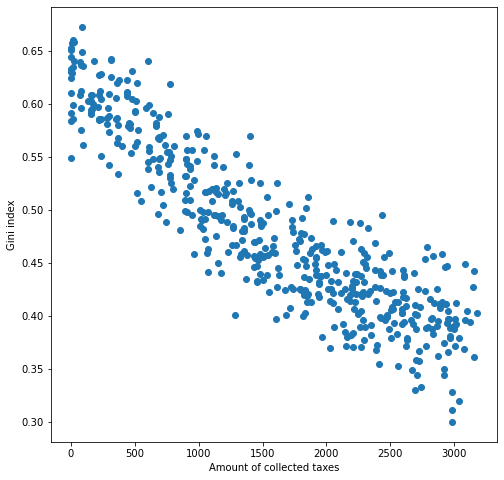

In [149]:
plt.scatter(run_data2.Tot_tax_per*(fixed_params['T']*fixed_params['N']-fixed_params['T'])*100/fixed_params['P'],run_data2.Gini)
plt.xlabel('Amount of collected taxes')
plt.ylabel('Gini index')

In [88]:
#def __init__(self, N, width, height, c, a, b, T,P)

fixed_params = {"N": 100,
                "width": 10,
                "height": 10,
                "c": 0,
                "a": 0,
                "T": 5,
                "P": 5,
                "ai": 0}

rangeb=np.arange(0,0.15,0.003)
variable_params = {"b": rangeb}

batch_run3 = BatchRunner(MoneyModel,
                        variable_params,
                        fixed_params,
                        iterations=10,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini,"Tot_tax_per": compute_tot_tax_per})
batch_run3.run_all()

500it [08:35,  1.03s/it]


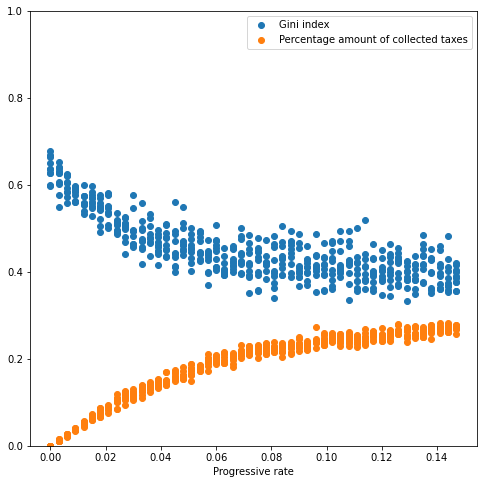

In [89]:
run_data3 = batch_run3.get_model_vars_dataframe()
run_data3.head()
plt.scatter(run_data3.b, run_data3.Gini, label='Gini index')
plt.scatter(run_data3.b, run_data3.Tot_tax_per, label='Percentage amount of collected taxes')

plt.xlabel('Progressive rate')
plt.legend()
plt.ylim([0,1])
plt.show()

Text(0, 0.5, 'Gini index')

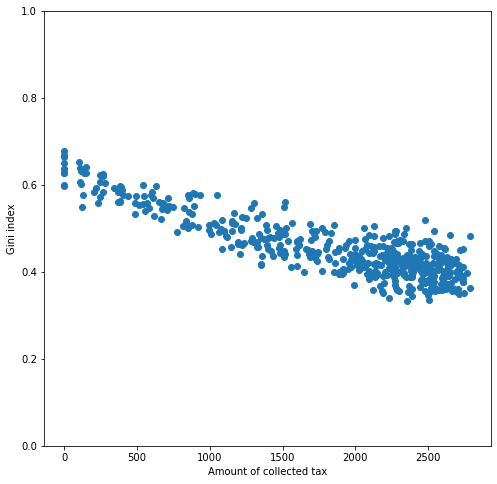

In [90]:
plt.scatter(run_data3.Tot_tax_per*(fixed_params['T']*fixed_params['N']-fixed_params['T'])*100/fixed_params['P'],run_data3.Gini)
plt.ylim([0,1])
plt.xlabel('Amount of collected tax')
plt.ylabel('Gini index')

In [115]:
#def __init__(self, N, width, height, c, a, b, T,P, ai)

fixed_params = {"N": 100,
                "width": 10,
                "height": 10,
                "c": 0,
                "a": 0,
                "b": 0,
                "T": 5,
                "P": 5}

rangeai=np.arange(0,1,0.02)
variable_params = {"ai": rangeai}

batch_run4 = BatchRunner(MoneyModel,
                        variable_params,
                        fixed_params,
                        iterations=10,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini,"tax_per_GDP": compute_tax_per_gdp, "GDP" : return_gdp})
batch_run4.run_all()

500it [07:56,  1.05it/s]


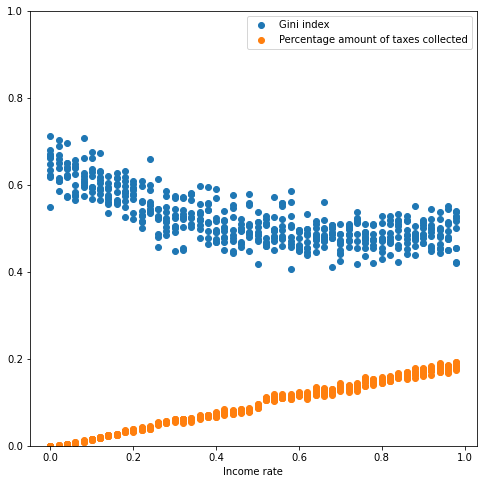

In [116]:
run_data4 = batch_run4.get_model_vars_dataframe()
run_data4.head()
plt.scatter(run_data4.ai, run_data4.Gini, label='Gini index')
plt.scatter(run_data4.ai, run_data4.tax_per_GDP, label='Percentage amount of taxes collected')

plt.xlabel('Income rate')
plt.legend()
plt.ylim([0,1])
plt.show()

Text(0, 0.5, 'Gini index')

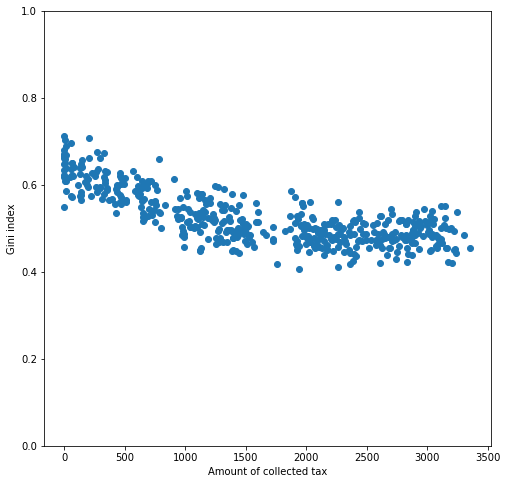

In [117]:
#scatter plot gini and tot tax

plt.scatter(run_data4.tax_per_GDP*run_data4.GDP,run_data4.Gini)
plt.ylim([0,1])
plt.xlabel('Amount of collected tax')
plt.ylabel('Gini index')

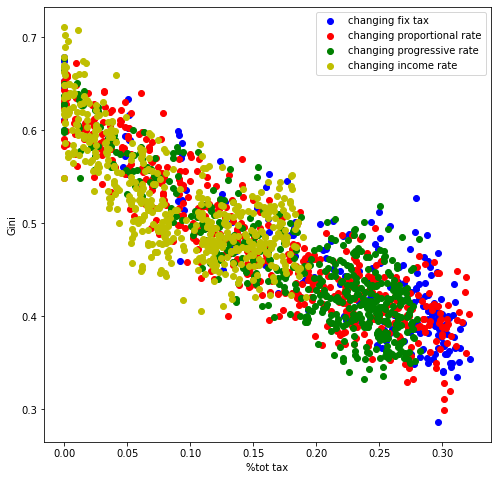

In [150]:
plt.scatter(run_data1.Tot_tax_per,run_data1.Gini, label='changing fix tax', color='b')
plt.scatter(run_data2.Tot_tax_per,run_data2.Gini, label='changing proportional rate', color='r')
plt.scatter(run_data3.Tot_tax_per,run_data3.Gini, label='changing progressive rate', color='g')
plt.scatter(run_data4.tax_per_GDP,run_data4.Gini, label='changing income rate', color='y')

plt.xlabel('%tot tax')
plt.ylabel('Gini')
plt.legend()
plt.show()

In [151]:
run_data1
data1_gini_mean=[]
data1_tottax_mean=[]
for c in rangec:
    x=list(run_data1.loc[run_data1['c']==c]['Gini'])
    y=sum(x)/len(x)
    data1_gini_mean.append(y)
    x1=list(run_data1.loc[run_data1['c']==c]['Tot_tax_per'])
    y1=sum(x1)/len(x1)*(fixed_params['T']*fixed_params['N']-fixed_params['T'])*100/fixed_params['P']
    data1_tottax_mean.append(y1)

In [152]:
run_data2
data2_gini_mean=[]
data2_tottax_mean=[]
for a in rangea:
    x=list(run_data2.loc[run_data2['a']==a]['Gini'])
    y=sum(x)/len(x)
    data2_gini_mean.append(y)
    x2=list(run_data2.loc[run_data2['a']==a]['Tot_tax_per'])
    y2=sum(x2)/len(x2)*(fixed_params['T']*fixed_params['N']-fixed_params['T'])*100/fixed_params['P']
    data2_tottax_mean.append(y2)

In [153]:
run_data3
data3_gini_mean=[]
data3_tottax_mean=[]
for b in rangeb:
    x=list(run_data3.loc[run_data3['b']==b]['Gini'])
    y=sum(x)/len(x)
    data3_gini_mean.append(y)
    x3=list(run_data3.loc[run_data3['b']==b]['Tot_tax_per'])
    y3=sum(x3)/len(x3)*(fixed_params['T']*fixed_params['N']-fixed_params['T'])*100/fixed_params['P']
    data3_tottax_mean.append(y3)

In [154]:
run_data4
data4_gini_mean=[]
data4_tottax_mean=[]
for ai in rangeai:
    x=list(run_data4.loc[run_data4['ai']==ai]['Gini'])
    y=sum(x)/len(x)
    data4_gini_mean.append(y)
    x4=list(run_data4.loc[run_data4['ai']==ai]['tax_per_GDP']*run_data4.loc[run_data4['ai']==ai]['GDP'])
    y4=sum(x4)/len(x4)
    data4_tottax_mean.append(y4)

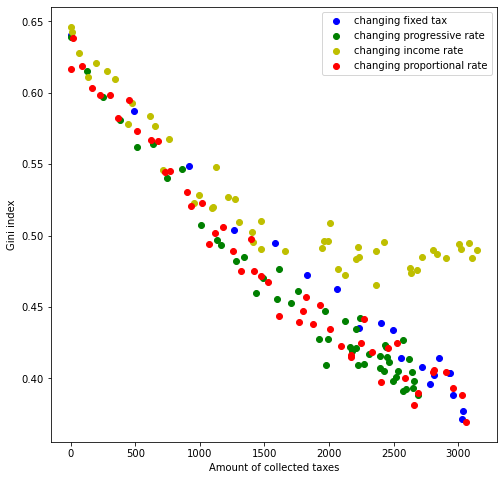

In [155]:
plt.scatter(data1_tottax_mean,data1_gini_mean, label='changing fixed tax', color='b')
plt.scatter(data3_tottax_mean,data3_gini_mean, label='changing progressive rate', color='g')
plt.scatter(data4_tottax_mean,data4_gini_mean, label='changing income rate', color='y')
plt.scatter(data2_tottax_mean,data2_gini_mean, label='changing proportional rate', color='r')
plt.xlabel('Amount of collected taxes')
plt.ylabel('Gini index')
plt.legend()
plt.show()

In [156]:
data1_g_t=pd.DataFrame(list(zip(data1_tottax_mean,data1_gini_mean)), columns =['Tax','Gini'])
data2_g_t=pd.DataFrame(list(zip(data2_tottax_mean,data2_gini_mean)), columns =['Tax','Gini'])
data3_g_t=pd.DataFrame(list(zip(data3_tottax_mean,data3_gini_mean)), columns =['Tax','Gini'])
data4_g_t=pd.DataFrame(list(zip(data4_tottax_mean,data4_gini_mean)), columns =['Tax','Gini'])
data1_g_t=data1_g_t.loc[(data1_g_t['Tax']<3000)&(data1_g_t['Tax']>0)]
data2_g_t=data2_g_t.loc[(data2_g_t['Tax']<3000)&(data2_g_t['Tax']>0)]
data3_g_t=data3_g_t.loc[(data3_g_t['Tax']<3000)&(data3_g_t['Tax']>0)]
data4_g_t=data4_g_t.loc[(data4_g_t['Tax']<3000)&(data4_g_t['Tax']>0)]

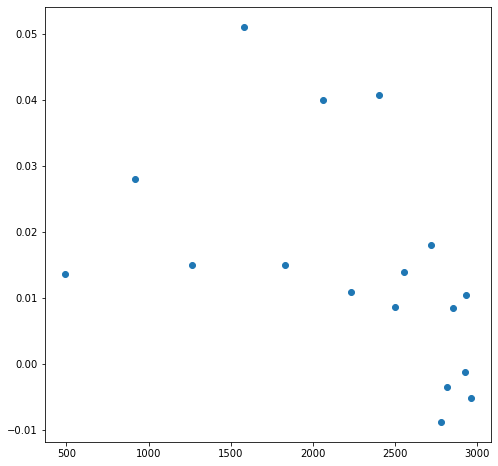

In [157]:
delta_c_a=[]
for x in data1_g_t['Tax']:
    lst=data2_g_t['Tax']
    absolute_difference_function = lambda lst_value : abs(lst_value - x)
    closest_value = min(lst, key=absolute_difference_function)
    y=data1_g_t.loc[data1_g_t['Tax']==x]['Gini'].item()-data2_g_t.loc[data2_g_t['Tax']==closest_value]['Gini'].item()
    delta_c_a.append(y)
    
plt.scatter(data1_g_t['Tax'],delta_c_a)

In [158]:
#one sample t-test

tscore, pvalue = ttest_1samp(delta_c_a, popmean=0)
print("t Statistic: ", tscore)  
print("P Value: ", pvalue/2) #one tail

if pvalue/2 <= 0.05:
    print("Since the p-value is smaller than 0.05 we can reject the null hyphothesis that the averange is equal than zero, good!")
else:
    print("oh shit, data are not significant..")

t Statistic:  3.7143316642141917
P Value:  0.0009422310321465276
Since the p-value is smaller than 0.05 we can reject the null hyphothesis that the averange is equal than zero, good!


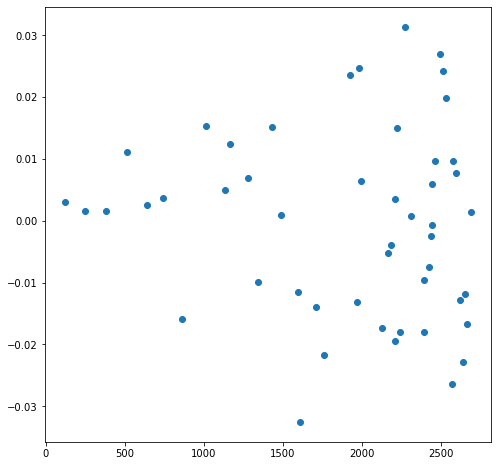

In [159]:
delta_b_a=[]
for x in data3_g_t['Tax']:
    lst=data2_g_t['Tax']
    absolute_difference_function = lambda lst_value : abs(lst_value - x)
    closest_value = min(lst, key=absolute_difference_function)
    y=data2_g_t.loc[data2_g_t['Tax']==closest_value]['Gini'].mean()-data3_g_t.loc[data3_g_t['Tax']==x]['Gini'].item()
    delta_b_a.append(y)
    
plt.scatter(data3_g_t['Tax'],delta_b_a)

In [160]:
#one sample t-test

tscore, pvalue = ttest_1samp(delta_b_a, popmean=0)
print("t Statistic: ", tscore)  
print("P Value: ", pvalue/2) #one tail

if pvalue/2 <= 0.05:
    print("Since the p-value is smaller than 0.05 we can reject the null hyphothesis that the averange is equal than zero, good!")
else:
    print("oh shit, data are not significant..")

t Statistic:  -0.19339401909184803
P Value:  0.4237332232204437
oh shit, data are not significant..


In [163]:
data2_g_t=data2_g_t.loc[(data2_g_t['Tax']<1500)&(data2_g_t['Tax']>0)]
data4_g_t=data4_g_t.loc[(data4_g_t['Tax']<1500)&(data4_g_t['Tax']>0)]

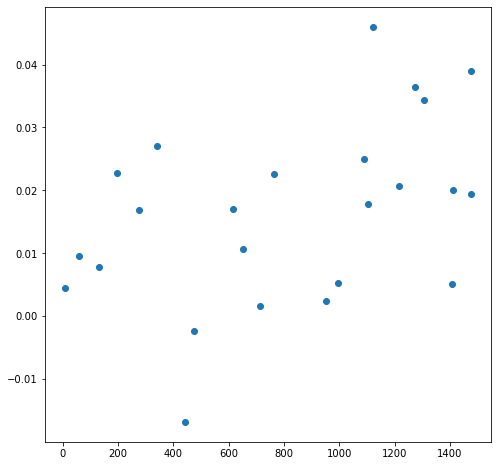

In [164]:
delta_ai_a=[]
for x in data4_g_t['Tax']:
    lst=data2_g_t['Tax']
    absolute_difference_function = lambda lst_value : abs(lst_value - x)
    closest_value = min(lst, key=absolute_difference_function)
    y=-(data2_g_t.loc[data2_g_t['Tax']==closest_value]['Gini'].mean()-data4_g_t.loc[data4_g_t['Tax']==x]['Gini'].item())
    delta_ai_a.append(y)
    
plt.scatter(data4_g_t['Tax'],delta_ai_a)

In [165]:
#one sample t-test

tscore, pvalue = ttest_1samp(delta_ai_a, popmean=0)
print("t Statistic: ", tscore)  
print("P Value: ", pvalue/2) #one tail

if pvalue/2 <= 0.05:
    print("Since the p-value is smaller than 0.05 we can reject the null hyphothesis that the averange is equal than zero, good!")
else:
    print("oh shit, data are not significant..")

t Statistic:  5.534187653459721
P Value:  6.2611595035913845e-06
Since the p-value is smaller than 0.05 we can reject the null hyphothesis that the averange is equal than zero, good!


_______________________________________________________________________________________________________________________________

In [ ]:
#def __init__(self, N, width, height, c, a, b, T,P,ai)

fixed_params = {"N": 100,
                "width": 10,
                "height": 10,
                "a": 0,
                "b": 0,
                "P": 10,
                "T": 5,
                "ai": 0}
variable_params = {"c": range(0,301,300)}

batch_run5 = BatchRunner(MoneyModel,
                        variable_params,
                        fixed_params,
                        iterations=50,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini})
batch_run5.run_all()

In [ ]:
run_data5 = batch_run5.get_model_vars_dataframe()
run_data5.head()
plt.scatter(run_data5.Run, run_data5.Gini)

plt.xlabel('iteration')
plt.ylabel('gini index')
plt.title('mercato libero & tassa esproprio')

plt.ylim([0,1])
plt.show()

In [ ]:
sum(run_data5[:50]['Gini'])/50 #gini nel mercato libero

In [ ]:
sum(run_data5[-50:]['Gini'])/50 #gini con tassa d'esproprio, C=tot denaro

In [ ]:
#def __init__(self, N, width, height, c, a, b, T,P,ai)

fixed_params = {"N": 100,
                "width": 10,
                "height": 10,
                "a": 0,
                "b": 0,
                "P": 10,
                "T": 5,
                "ai": 0}
variable_params = {"c": range(0,301,300)}

batch_run6 = BatchRunner(MoneyModel,
                        variable_params,
                        fixed_params,
                        iterations=50,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini})
batch_run6.run_all()

In [ ]:
run_data6 = batch_run6.get_model_vars_dataframe()
run_data6.head()

In [ ]:
plt.scatter(run_data5.Run, run_data5.Gini, label="Thelf-Fraud model")
plt.scatter(run_data6.Run, run_data6.Gini, label="Yard-Sale model")

plt.xlabel('iteration')
plt.ylabel('gini index')

plt.ylim([0,1])
plt.legend()
plt.show()

In [ ]:
sum(run_data6[:50]['Gini'])/50 #gini nel mercato libero

In [ ]:
sum(run_data6[-50:]['Gini'])/50 